In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import os
from pandas.plotting import autocorrelation_plot


import warnings
import itertools

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [16]:
wages_path = 'wages.xlsx'

wages = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW','VIC','QLD','SA','WA','TAS','NT'])
wages = pd.DataFrame(wages)
wages = wages.set_index('time').asfreq('QS-DEC')

# Read the Excel file into a pandas DataFrame
wages_pre_covid =wages.iloc[:40]
wages_during_covid =wages.iloc[40:52]
wages_post_covid =wages.iloc[52:]


In [17]:
wages_nsw = wages['NSW']
wages_vic = wages['VIC']
wages_qld = wages['QLD']
wages_sa = wages['SA']
wages_wa = wages['WA']
wages_tas = wages['TAS']
wages_nt = wages['NT']

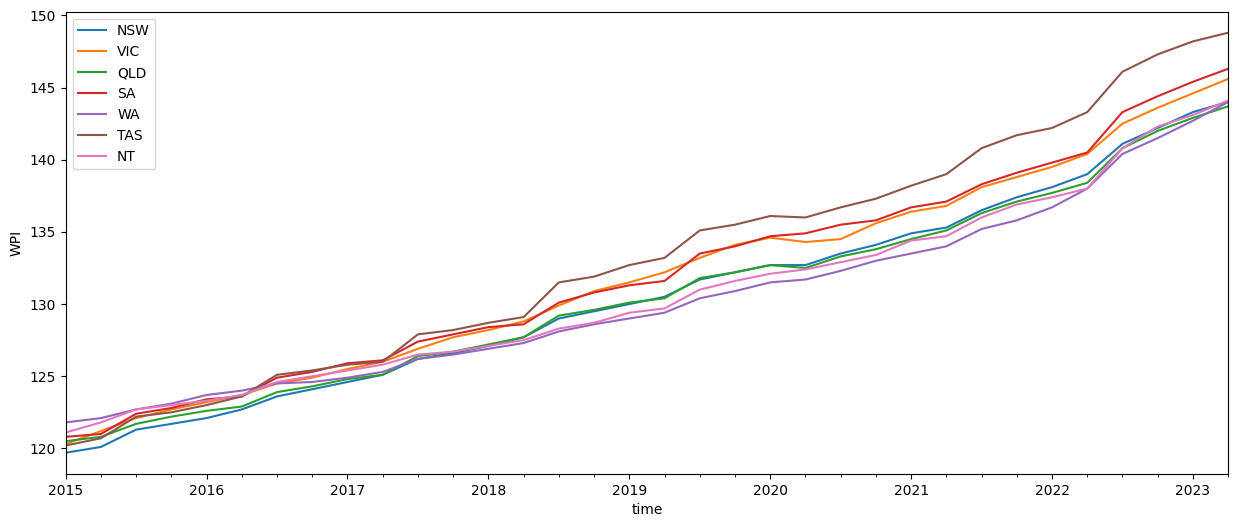

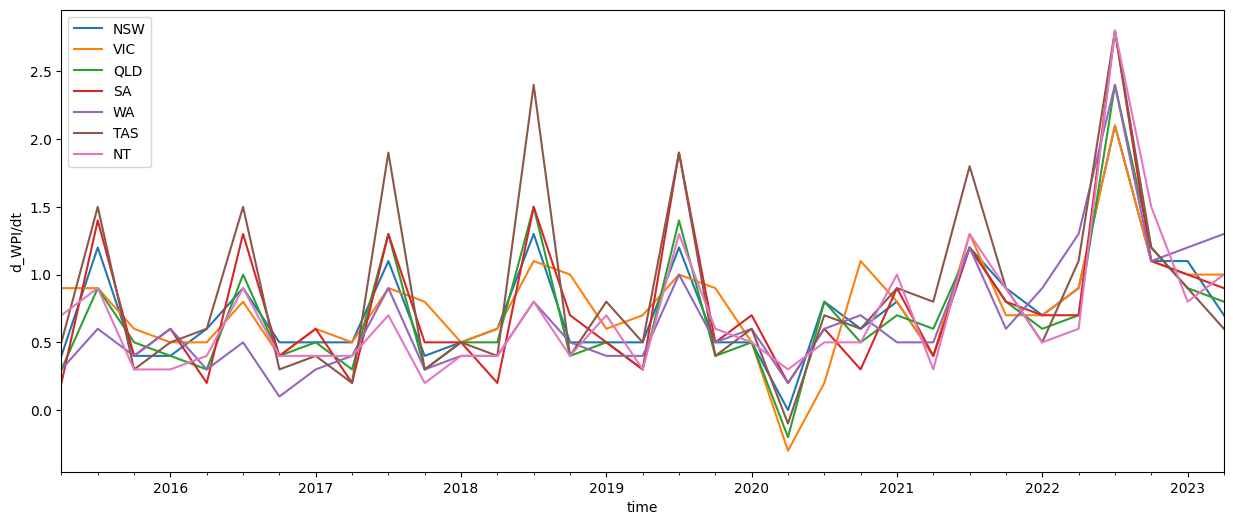

In [18]:
wages = wages.iloc[20:]
wages.plot(figsize=(15, 6))
plt.ylabel("WPI")
plt.savefig('WPI over states.png')

wages_change = wages.diff().dropna()
wages_change.plot(figsize=(15, 6))
plt.ylabel("d_WPI/dt")
plt.savefig('change in WPI over states.png')

In [19]:
wages_pre_covid_nsw = wages_pre_covid['NSW']
wages_pre_covid_vic = wages_pre_covid['VIC']
wages_pre_covid_qld = wages_pre_covid['QLD']
wages_pre_covid_sa = wages_pre_covid['SA']
wages_pre_covid_wa = wages_pre_covid['WA']
wages_pre_covid_tas = wages_pre_covid['TAS']
wages_pre_covid_nt = wages_pre_covid['NT']

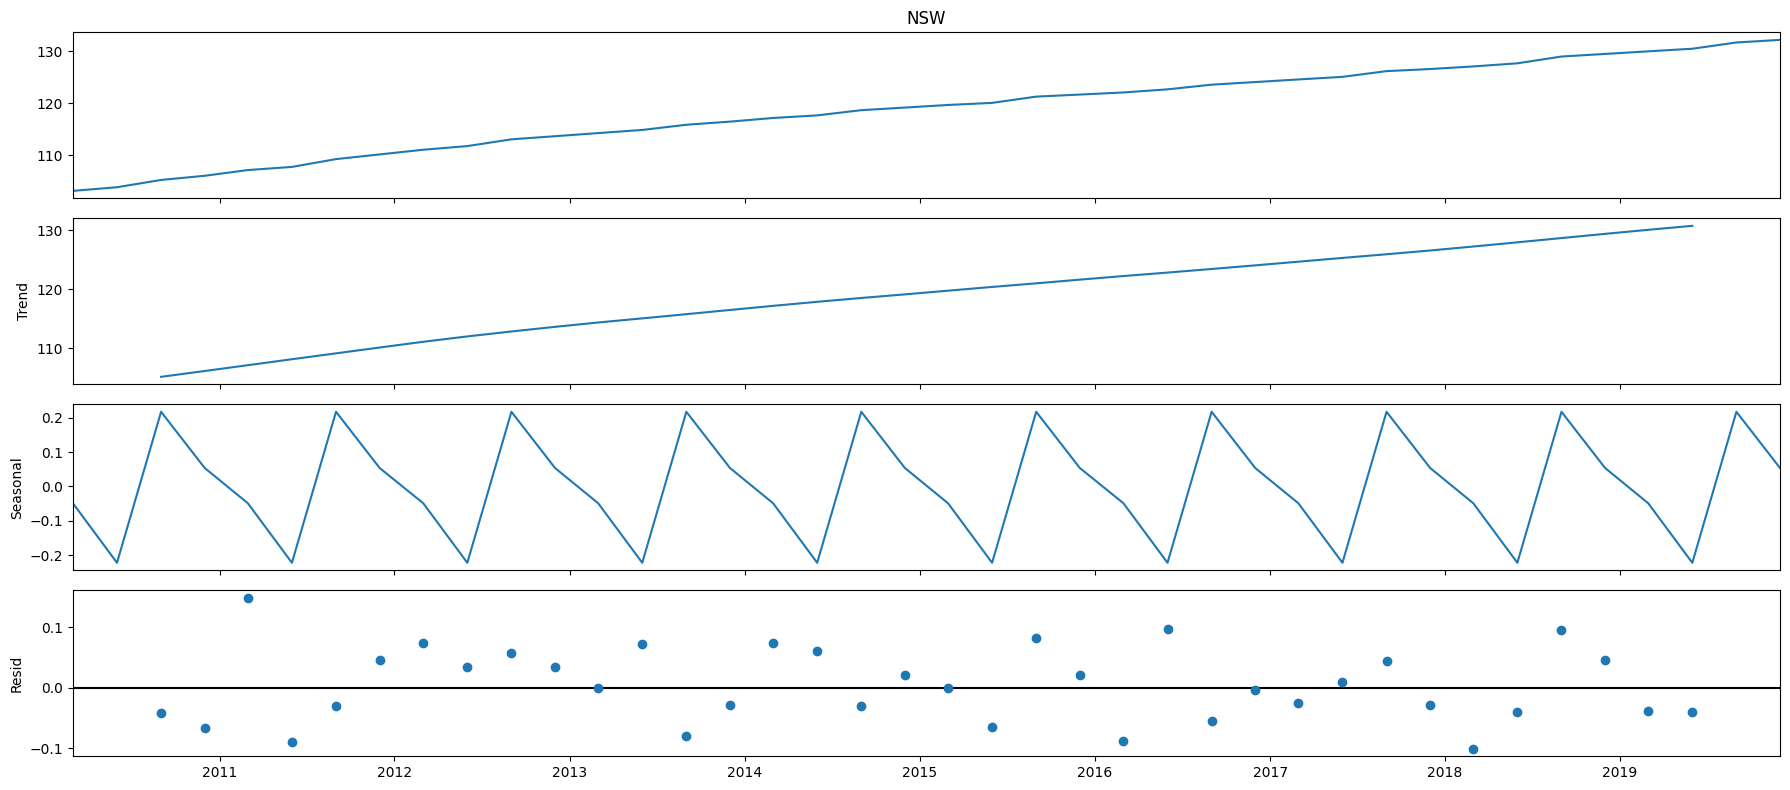

In [20]:
# NSW
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(wages_pre_covid_nsw, model='additive')
decomposition.plot()
plt.savefig('NSW WPI seasonal_decompose.png')
plt.show()


Time series forecasting with ARIMA


In [21]:
def adfuller_test(wage):
    result=adfuller(wage)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(wages_pre_covid_nsw)

ADF Test Statistic : 0.10233211921497314
p-value : 0.966219958446506
#Lags Used : 4
Number of Observations : 35
weak evidence against null hypothesis,indicating it is non-stationary 


In [22]:
wages_pre_covid_nsw = wages_pre_covid_nsw.diff().dropna()

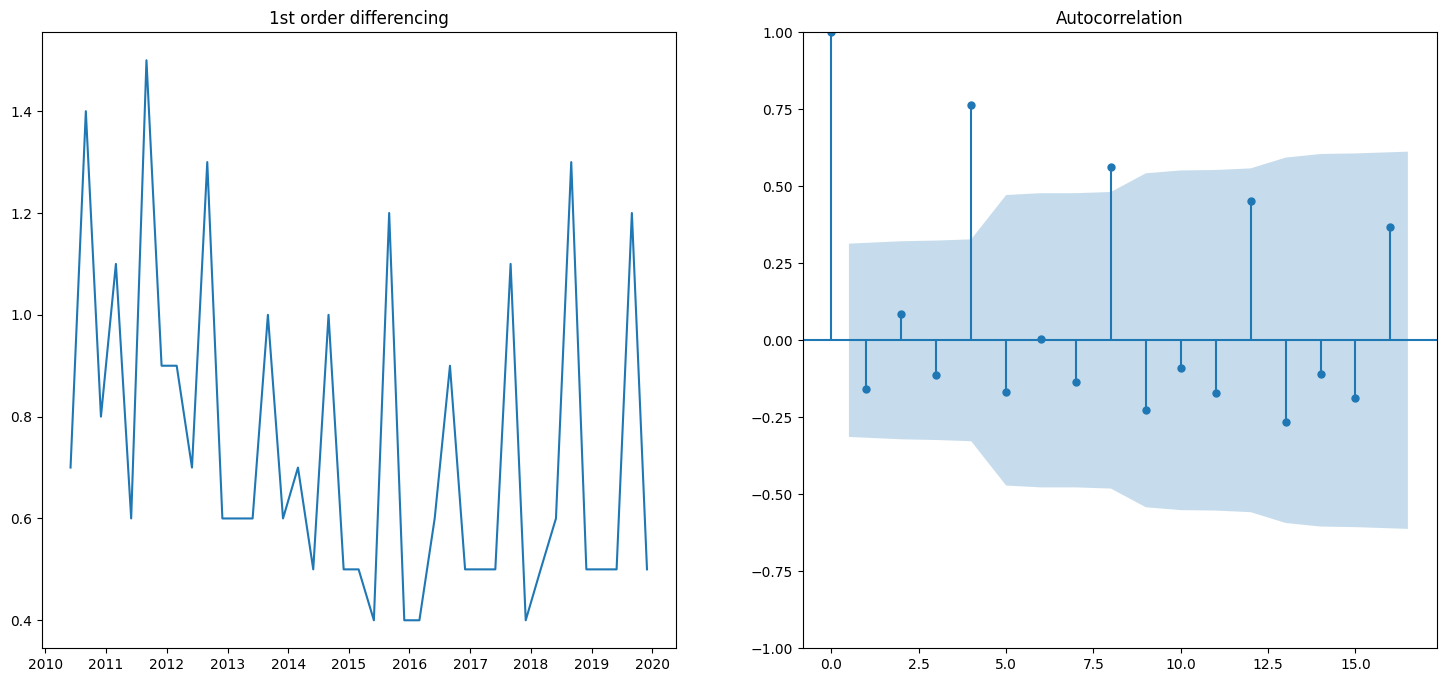

In [23]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(wages_pre_covid_nsw)

ax2 = f.add_subplot(122)
plot_acf(wages_pre_covid_nsw, ax=ax2)
plt.savefig('NSW WPI 1st order autococorrelation.png')
plt.show()

In [24]:
def adfuller_test(wage):
    result=adfuller(wage)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(wages_pre_covid_nsw)

ADF Test Statistic : -3.4902046879402904
p-value : 0.00824225098484166
#Lags Used : 10
Number of Observations : 28
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


As from the above observation, after the first order differencing, the p-value drops beyond the threshold order and shows strong evidence against the null hypothesis, sp taking "d" as 2. 

We see the 4th lag is the most significant. so p is 4.

There are 2 lags crossed the threshold, so q is 2.


In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param_seasonal in seasonal_pdq:
    try:
        mod_nsw = sm.tsa.statespace.SARIMAX(wages_pre_covid_nsw,
                                            order=(4, 2, 2),
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        results_nsw  = mod_nsw.fit()
        print('ARIMA(4, 2, 2)x{}12 - AIC:{}'.format(param_seasonal, results_nsw.aic))
    except:
        continue

ARIMA(4, 2, 2)x(0, 0, 0, 12)12 - AIC:-16.26750337460614
ARIMA(4, 2, 2)x(0, 0, 1, 12)12 - AIC:1001.1339634503665


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(4, 2, 2)x(0, 1, 0, 12)12 - AIC:-9.348936001512598


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 2)x(0, 1, 1, 12)12 - AIC:-9.893139108163851
ARIMA(4, 2, 2)x(1, 0, 0, 12)12 - AIC:-7.4159772179034285


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 2)x(1, 0, 1, 12)12 - AIC:-5.149638317805682
ARIMA(4, 2, 2)x(1, 1, 0, 12)12 - AIC:-4.059772086727975
ARIMA(4, 2, 2)x(1, 1, 1, 12)12 - AIC:10.314819651559171


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
#(p, d, q)

mod_nsw = sm.tsa.statespace.SARIMAX(wages_pre_covid_nsw,
                                order=(4, 2, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_nsw = mod_nsw.fit()
print(results_nsw.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3962      0.213     -6.546      0.000      -1.814      -0.978
ar.L2         -1.3191      0.304     -4.334      0.000      -1.916      -0.723
ar.L3         -0.9262      0.273     -3.395      0.001      -1.461      -0.391
ar.L4         -0.4768      0.179     -2.664      0.008      -0.828      -0.126
sigma2         0.0207      0.009      2.343      0.019       0.003       0.038


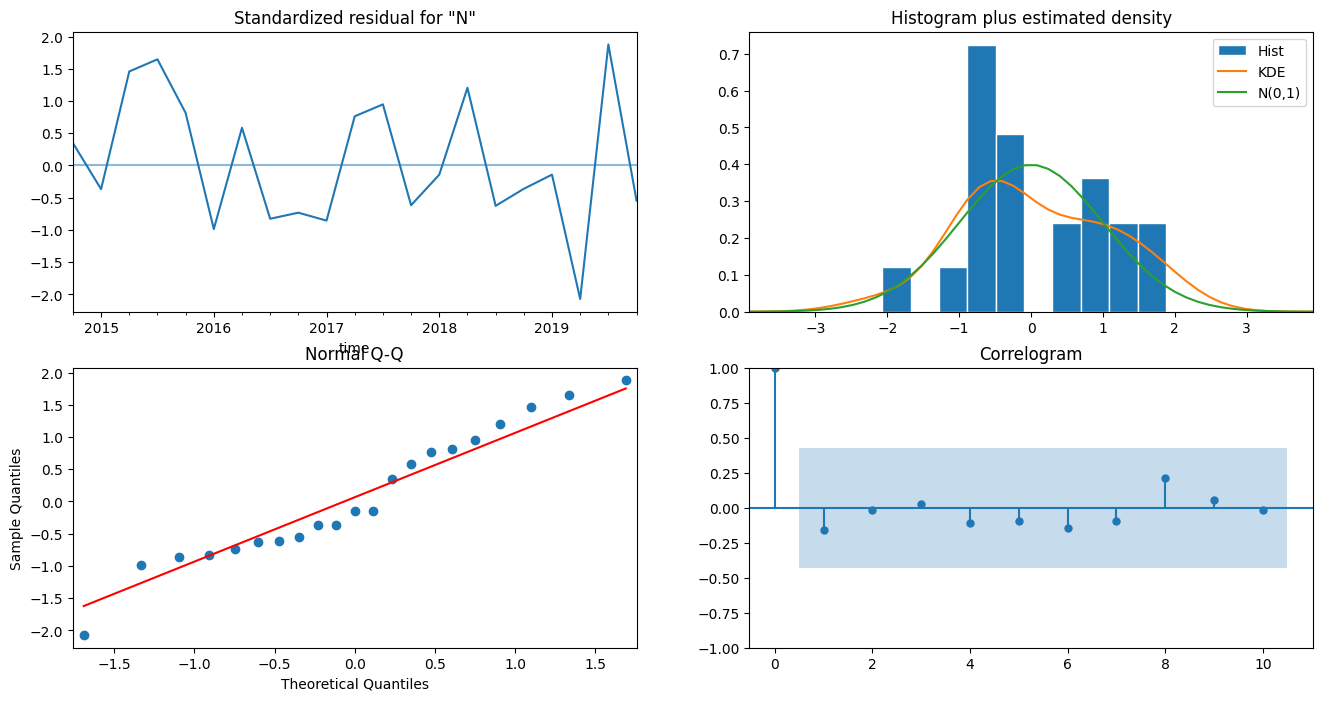

In [27]:
results_nsw.plot_diagnostics(figsize=(16, 8))
ax1.plot(wages_pre_covid_nsw)
plt.savefig('NSW WPI SARIMAX.png')
plt.show()

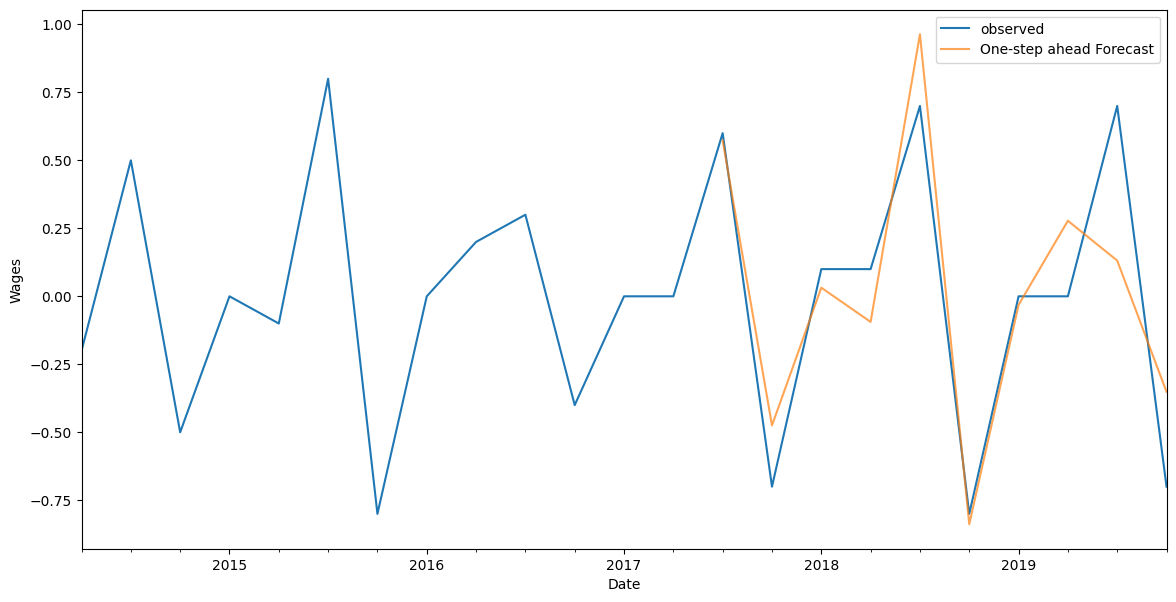

In [29]:
pred = results_nsw.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int().diff().dropna()
ax = wages_pre_covid_nsw['2014':].diff().dropna().plot(label='observed')

pred.predicted_mean.diff().dropna().plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Wages')
plt.legend()
plt.savefig('fitting.png')
plt.show()

             lower NSW   upper NSW  Predictions
2020-03-01  132.524006  133.074764   132.799385
2020-06-01  132.951902  133.820933   133.386417
2020-09-01  133.950641  135.194145   134.572393
2020-12-01  134.231086  135.898415   135.064750
2021-03-01  134.580512  136.716509   135.648511
2021-06-01  135.013337  137.661098   136.337217
2021-09-01  136.128891  139.320350   137.724621
2021-12-01  136.427519  140.196792   138.312155
2022-03-01  136.710427  141.089071   138.899749
2022-06-01  136.978195  141.996147   139.487171
2022-09-01  137.931859  143.617664   140.774761
2022-12-01  138.171815  144.552735   141.362275
2023-03-01  138.368751  145.729628   142.049189
2023-06-01  138.531712  146.915789   142.723750


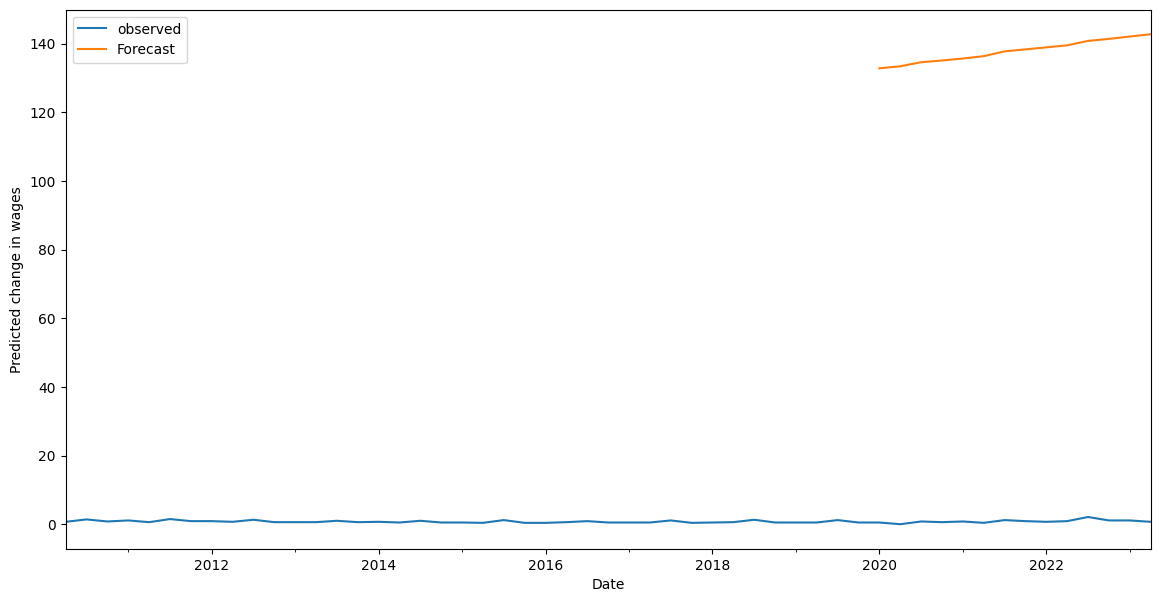

In [34]:
pred_uc = results_nsw.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()
ax = wages_nsw.diff().dropna().plot(label='observed', figsize=(14, 7))

pred_ci["Predictions"] = pred_uc.predicted_mean
print(pred_ci)


pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted change in wages')
plt.legend()
plt.savefig('NSW change in PWI predicted.png')
plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7795      0.277     -2.817      0.005      -1.322      -0.237
ar.L2         -0.4337      0.476     -0.911      0.362      -1.366       0.499
ar.L3         -0.1952      0.401     -0.487      0.626      -0.981       0.591
ar.L4         -0.0653      0.185     -0.352      0.725      -0.429       0.298
sigma2         0.0197      0.008      2.367      0.018       0.003       0.036
             lower NSW   upper NSW  Predictions_wage
2020-03-01  132.524006  133.074764        132.799385
2020-06-01  132.951902  133.820933        133.386417
2020-09-01  133.950641  135.194145        134.572393
2020-12-01  134.231086  135.898415        135.064750
2021-03-01  134.580512  136.716509        135.648511
2021-06-01  135.013337  137.661098        136.337217
2021-09-01  136.128891  139.320350        137.724621
2021-12-01  136.427519 

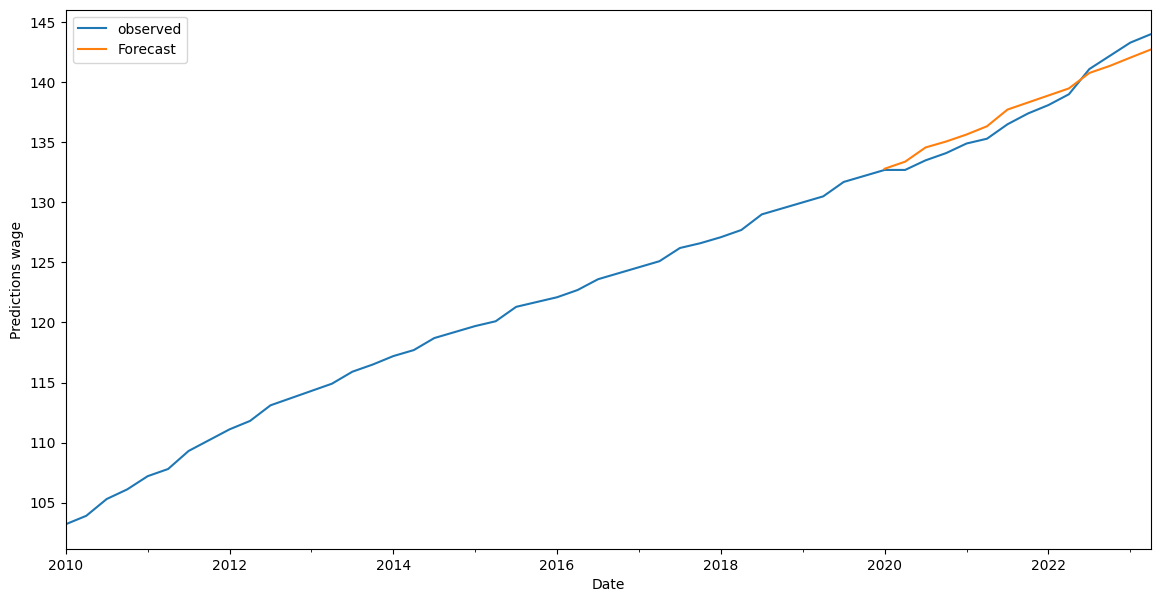

In [33]:
wages_pre_covid_nsw = wages_pre_covid['NSW']

mod_nsw = sm.tsa.statespace.SARIMAX(wages_pre_covid_nsw,
                                order=(4, 2, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_nsw = mod_nsw.fit()
print(results_nsw.summary().tables[1])

pred_uc = results_nsw.get_forecast(steps=14)
pred_ci = pred_uc.conf_int() 
pred_ci["Predictions_wage"] = pred_uc.predicted_mean
print(pred_ci)

ax = wages_nsw.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Predictions wage')
plt.savefig('NSW predicted PWI.png')
plt.legend()
plt.show()